# Neural Network to classify Horses or Humans from dataset

## Required libraries

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets

## Load dataset

In [26]:
dataset_base_path = r'Data/horses-or-humans-dataset/horse-or-human'

dataset_train_path = dataset_base_path + '/train'
dataset_valid_path = dataset_base_path + '/validation'

train_horses_path = dataset_train_path + '/horses'
train_humans_path = dataset_train_path + '/humans'

valid_horses_path = dataset_valid_path + '/horses'
valid_humans_path = dataset_valid_path + '/humans'

batch_size = 10

In [27]:
transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder(dataset_train_path, transform=transformations)
valid_dataset = datasets.ImageFolder(dataset_valid_path, transform=transformations)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

unloader = transforms.ToPILImage()

## Plot sample images

In [43]:
train_iter = iter(trainloader)
images, labels = train_iter.next()
print(type(images))
print(images.shape)
print(type(labels))
print(labels.shape)

images = images.numpy()
print(images.shape)

<class 'torch.Tensor'>
torch.Size([10, 3, 300, 300])
<class 'torch.Tensor'>
torch.Size([10])
(10, 3, 300, 300)


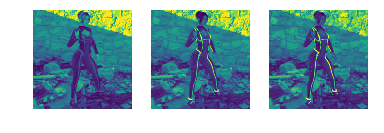

In [44]:
# Plot an image for all 3 channels separately
img_0_0 = images[0, 0, :, :] # First image, 1st channel, all pixels
img_0_1 = images[0, 1, :, :] # First image, 2nd channel, all pixels
img_0_2 = images[0, 2, :, :] # First image, 3rd channel, all pixels

plt.subplot(131)
plt.imshow(img_0_0)
plt.axis('off')

plt.subplot(132)
plt.imshow(img_0_1)
plt.axis('off')

plt.subplot(133)
plt.imshow(img_0_2)
plt.axis('off')

plt.show()

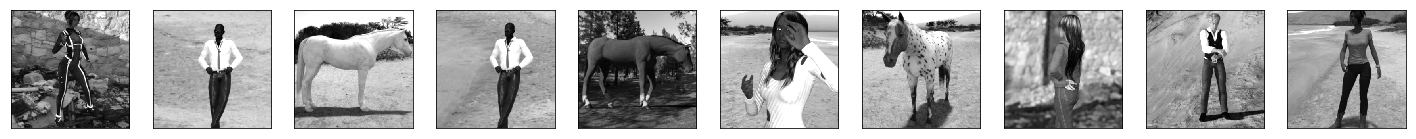

In [49]:
# plot the images in the batch
images_2 = images[:, 2, :, :]
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_2[idx]), 'gray')

## Design Neural network

Points to remember:

+ Input neurons of next layer => $(W - F + 2*P)/S + 1$ where, 
  + W = input neurons
  + F = Filter or Kernel size
  + P = Padding
  + S = Stride

In [59]:
class HumansOrHorses(nn.Module):
    def __init__(self):
        super(HumansOrHorses, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        self.conv4 = nn.Conv2d(16, 32, 3)

        self.pool = nn.MaxPool2d(2, 2)

        # 32 * 8 * 8 => 2048
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # 3 x 300 x 300 => 4 x 298 x 298
        x = F.relu(self.conv2(x)) # 4 x 298 x 298 => 8 x 296 x 296
        x = self.pool(x) # 8 x 296 x 296 => 8 x 148 x 148
        x = self.pool(x) # 8 x 148 x 148 => 8 x 74 x 74
        x = F.relu(self.conv3(x)) # 8 x 74 x 74 => 16 x 72 x 72
        x = self.pool(x) # 16 x 72 x 72 => 16 x 36 x 36
        x = self.pool(x) # 16 x 36 x 36 => 16 x 18 x 18
        x = F.relu(self.conv4(x)) # 16 x 18 x 18 => 32 x 16 x 16
        x = self.pool(x) # 32 x 16 x 16 => 32 x 8 x 8

        # flatten image input
        x = x.view(-1, 32 * 8 * 8) # 32 * 8 * 8  => 2048
        # add 1st linear layer, with relu activation function
        x = F.relu(self.fc1(x)) # 2048 => 512
        # add 2nd linear layer
        x = self.fc2(x) # 512 => 1
        return x

In [60]:
net = HumansOrHorses()

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr = 0.01)

In [66]:
print('training started\n')

epochs = 100
for epoch in range(epochs):
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #labels = labels.unsqueeze(1)
        #labels = labels.type(torch.FloatTensor)
        
        optimizer.zero_grad()

        output = net(inputs)
        
        output = output.type(torch.FloatTensor)
        loss = criterion(output, labels)

        loss.backward() # updates weights
        optimizer.step() # Reduces loss function. Helps in Backward propogation

        running_loss += loss.item()
        if i%50 == 49:
            print('iter:{0}, loss:{1}'.format(i, loss.item()))
            print('epoch:{0}, loss:{1}'.format(epoch+1, running_loss/50))
            running_loss = 0.0
    print('epoch:{0}, loss:{1}'.format(epoch+1, running_loss))

print('\n training finished')

training started



RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at ..\aten\src\THNN/generic/ClassNLLCriterion.c:92